### Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from numpy.random import randn, rand
from scipy.io import loadmat
import time
from functools import wraps

### Runtime

In [3]:
def runtime(func):
    @wraps(func)
    def runtime_wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        total_time = end_time - start_time
        print("\n", f'Function {func.__name__} took {total_time:.4f} seconds')
        return result
    return runtime_wrapper

### Read data

In [40]:
# Note that there are several shapes in the LASA Handwriting dataset

name_of_dataset = 'Angle'
#name_of_dataset = 'CShape'
# name_of_dataset = 'GShape'
#name_of_dataset = 'JShape'
#name_of_dataset = 'Sshape'
#name_of_dataset = 'Worm'
#name_of_dataset = 'Multi_Models_1'
#name_of_dataset = 'Multi_Models_2'
#name_of_dataset = 'Multi_Models_3'
#name_of_dataset = 'Multi_Models_4' # two pattern


dataset = loadmat("../Dataset/" + name_of_dataset + '.mat')

# Unpack the trajectories and place into x and y used in learning step
num_of_demos = dataset['demos'].shape[1]
size_of_state = dataset['demos'][0, 0][0,0][0].shape[0]
dim_of_function = size_of_state 

x_cell = np.zeros((1, num_of_demos))
y_cell = np.zeros((1, num_of_demos))

In [31]:
# We need an init position for future simulation of learnt system
init_position_of_demos = np.zeros((size_of_state, num_of_demos))

# Python way to recreate cell array in matlab
x_cell = None 
y_cell = None

# Concatenating the dataseries of position and velocities
for i in range(0, num_of_demos):
    demo_struct = dataset['demos'][0,i][0,0]

    position_dataseries = dataset['demos'][0,i][0,0][0]
    velocity_dataseries = dataset['demos'][0,i][0,0][2] # is at position 3 in .mat file
    init_position_of_demos[:,i] = position_dataseries[:,0]
    # create x_cell if not existing
    if x_cell is None:
        x_cell = position_dataseries
    else : 
        # Example: two arrays of (2,1000) (2,1000) -> get 1 array with (2,2000)
        x_cell = np.concatenate((x_cell, position_dataseries), axis = 1)
    if y_cell is None:
        y_cell = velocity_dataseries
    else : 
        y_cell = np.concatenate((y_cell, velocity_dataseries), axis = 1)

x_train = x_cell # (2, 7000)
y_train = y_cell

num_of_points = x_train.shape[1]

# Get time info for simulating the learnt system later
time_step = dataset['dt'][0,0] # good

len_of_dataseries = dataset['demos'][0, 0][0,0][0].shape[1]

concatenate = np.concatenate((np.array([[0]]), time_step * np.ones((1, len_of_dataseries - 1))),axis=1) # axis = 1 is to concatenate at the second dimension
time_series = np.cumsum(concatenate)
num_of_timesteps = len_of_dataseries

# Intial starting point for the simulated trajectory using learnt model
#init_condition = stat.mean(init_position_of_demos[1]) # Average starting point of all demos
init_condition = init_position_of_demos.mean(axis = 1) # computes the mean across each columns

#### Mean of dataset

In [61]:
num_of_train_datasets = 4

pos_cell_1 = np.zeros((1000, 4))
pos_cell_2 = np.zeros((1000, 4))
vel_cell_1 = np.zeros((1000, 4))
vel_cell_2 = np.zeros((1000, 4))

# Concatenating the dataseries of position and velocities
for i in range(0, num_of_train_datasets):
    demo_struct = dataset['demos'][0,i][0,0]

    position_dataseries = dataset['demos'][0,i][0,0][0]
    velocity_dataseries = dataset['demos'][0,i][0,0][2] # is at position 3 in .mat file

    pos_cell_1[:, i] = position_dataseries[0]
    pos_cell_2[:, i] = position_dataseries[1]
    vel_cell_1[:, i] = velocity_dataseries[0]
    vel_cell_2[:, i] = velocity_dataseries[1]

x_train_1 = pos_cell_1.mean(axis=1) # computes the mean across each columns
x_train_2 = pos_cell_2.mean(axis=1) # computes the mean across each columns
y_train_1 = vel_cell_1.mean(axis=1) # computes the mean across each columns
y_train_2 = vel_cell_2.mean(axis=1)
print(x_train_1)

x_train = np.array([x_train_1, x_train_2])
y_train = np.array([y_train_1, y_train_2])

num_of_points = x_train.shape[1]

<class 'numpy.ndarray'>
[-4.42241379e+01 -4.42146482e+01 -4.42056763e+01 -4.41976747e+01
 -4.41910006e+01 -4.41854495e+01 -4.41805933e+01 -4.41760527e+01
 -4.41708116e+01 -4.41638209e+01 -4.41550281e+01 -4.41446313e+01
 -4.41327708e+01 -4.41226320e+01 -4.41122437e+01 -4.41015887e+01
 -4.40906446e+01 -4.40793840e+01 -4.40677704e+01 -4.40557580e+01
 -4.40432924e+01 -4.40303296e+01 -4.40168395e+01 -4.40027995e+01
 -4.39881781e+01 -4.39729231e+01 -4.39569946e+01 -4.39403988e+01
 -4.39232245e+01 -4.39056054e+01 -4.38876140e+01 -4.38692869e+01
 -4.38506412e+01 -4.38316749e+01 -4.38123666e+01 -4.37927026e+01
 -4.37726856e+01 -4.37523134e+01 -4.37313288e+01 -4.37096910e+01
 -4.36873873e+01 -4.36644106e+01 -4.36407565e+01 -4.36164150e+01
 -4.35913770e+01 -4.35656427e+01 -4.35392233e+01 -4.35121293e+01
 -4.34843655e+01 -4.34559567e+01 -4.34269572e+01 -4.33974098e+01
 -4.33673214e+01 -4.33366942e+01 -4.33055386e+01 -4.32738802e+01
 -4.32417479e+01 -4.32091618e+01 -4.31761305e+01 -4.31426828e+01
 

#### Plot dataset (state trajectory with velocities as arrows)

C:\Users\vilde\AppData\Local\Temp\ipykernel_7072\1901655976.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_dataset.show()


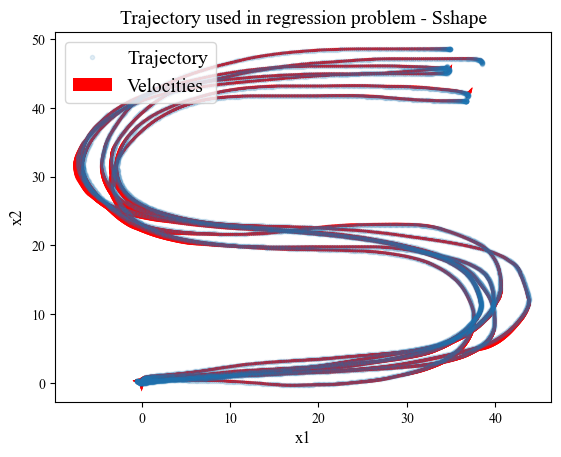

In [15]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": "Times New Roman",
})

fig_dataset = plt.figure(1)
plt.title('Trajectory used in regression problem - ' + name_of_dataset, fontsize=14)
plt.plot(x_train[0,:], x_train[1,:], '.', alpha = 0.12)
plt.quiver(x_train[0,:], x_train[1,:], y_train[0,:], y_train[1,:], color = 'red', scale = 700)
plt.xlabel('x1', fontsize =12)
plt.ylabel('x2', fontsize=12)
plt.legend(['Trajectory', 'Velocities'], loc = "upper left" , frameon = True , prop ={'size': 14 } )
fig_dataset.show()
#plt.savefig("../src/figures_plot/lasa_datatset.eps", format ="eps")

axes = plt.gca() #gca = get current axes, from my last plot

### From notebook: vector_valued_with_rff

In [16]:
def psi(x, w, b):
    return np.sqrt(2) * np.cos(w.T@x + b)

def psi_vector(x, w, b, m):
    psi_vector = np.zeros(m)
    for i in range(m):
        x = x.reshape((-1,))
        psi_vector[i] = psi(x, w[:, i], b[:,i])
    return np.array(psi_vector)

def capital_psi(x, w, b, m, dim):
    psi = psi_vector(x,w,b,m)
    return np.kron(psi, np.eye(dim))

def phi(x, w, b, n, m, dim):
    phi = np.zeros((dim*n, dim*m))
    for i in range(0, n):
        psi = capital_psi(x[:,i], w, b, m, dim)
        phi[dim*i] = psi[0]
        phi[dim*i+1] = psi[1]
    return phi

def alpha_approx(x_vector, y, dim, m, lam, n):
    phi_ = phi(x_vector, w, b, n, m, dim)
    alpha_inv_part = np.linalg.inv(phi_.T @ phi_ + lam*np.eye(dim*m))
    y_reshaped = np.array(np.ravel([y[0], y[1]], 'F'))
    alpha = alpha_inv_part @ (phi_.T @ y_reshaped)
    return alpha


### Random Fourier Features & Regression

In [17]:
sigma = 5
num_of_samples = 50

w = randn(size_of_state, num_of_samples)/sigma
b = rand(1,num_of_samples)*2*np.pi

# Random Fourier features approx
lambda_ = 0.001 # regularization parameter lamda

alpha_array_rff = alpha_approx(x_train, y_train, dim_of_function, num_of_samples, lambda_, num_of_points)

# Create callable function for learnt dynamics (straight from working note)
def learnt_model(t, x):
    func = capital_psi(x, w, b, num_of_samples, dim_of_function) @ alpha_array_rff
    return func

# learnt_model as lambda function
#F = lambda t, x: capital_psi(x, w, b, num_of_samples, dim_of_function) @ alpha_array_rff

#### Solve diff. equation using learnt model w. solver_ivp

In [18]:
timespan = np.array([time_series[0],time_series[-1]])
t = np.linspace(time_series[0],time_series[-1], 1000)
data_series = solve_ivp(learnt_model, timespan, init_condition, t_eval = t).y

### Plot simulated trajectory and streamslices for learnt model

In [19]:
# Get lower and upper bound for plotting from dataset figure
lower_bound_x1 = axes.get_xlim()[0]
upper_bound_x1 = axes.get_xlim()[1]
lower_bound_x2 = axes.get_ylim()[0]
upper_bound_x2 = axes.get_ylim()[1]

num_of_points = 17

x1 = np.linspace(lower_bound_x1, upper_bound_x1, num_of_points)
x2 = np.linspace(lower_bound_x2, upper_bound_x2, num_of_points)

# Base point or starting point for each vector of the vector field
[X1, X2] = np.meshgrid(x1, x2)

# Calculate df/dt for each point
t = 0

#print(data_series)
u_learnt = np.zeros(X1.shape)
v_learnt = np.zeros(X1.shape)

# for loop to get the velocity at each point witht the learnt model
for (i,j), value in np.ndenumerate(X1):

    # get velocities at each point with the learnt model
    Y_prime = learnt_model(t, np.array([value, X2[i, j]]))
    u_learnt[i,j] = Y_prime[0]
    v_learnt[i,j] = Y_prime[1]

#### Combined solution and vector field for learnt model

C:\Users\vilde\AppData\Local\Temp\ipykernel_7072\2908079441.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_learntmodel.show()


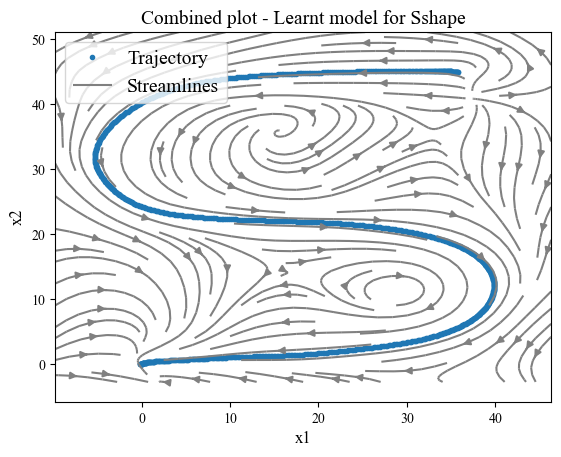

In [20]:
fig_learntmodel = plt.figure(2)
plt.title('Combined plot - Learnt model for ' + name_of_dataset, fontsize=14)
plt.plot(data_series[0, :], data_series[1, :], '.', linewidth=0.1)
plt.streamplot(X1, X2, u_learnt, v_learnt, density = 1.1, color ='gray')
plt.xlabel('x1', fontsize=12)
plt.ylabel('x2', fontsize=12)
plt.legend(['Trajectory', 'Streamlines'], loc = "upper left" , frameon = True , prop ={'size': 14 } )
fig_learntmodel.show()
#plt.savefig("../src/figures_plot/lasa_learnt_model.eps", format ="eps")
